# Deep KNN

Este notebook tem como objetivo propor uma maneira alternativa de realizar classificação de imagens com deep learning, atravez da combinação de redes neurais profundas pretreinadas e da tecnica Knn. Esta combinação visa unir os beneficios da representação hierarquica de uma rede neural ja treinada com a necessidade de menos dados menos dados de um Knn. 

# Modelo proposto

### Arquitetura

O modelo aqui proposto consiste na utilização de uma rede pretreinada chamada [InceptionV3](https://keras.io/applications/#inceptionv3) sem sua ultima camada (predictions) e uma implementação do algoritimo Knn, desta forma a saida da rede neural deixa de ser a classificação original e passa a ser um vetor de 2048 posições que sera utilizado como entrada para o Knn.

### Fase de treino

Para realizar o treinamento o dataset de treino deve passar pela rede neural no sentido forward e o seu resultado deve ser passado ao Knn com a sua respectiva classe para treina-lo.

### Fase de teste e predição

A realização da predição é bem similar a realização do treino, para ser classificada uma foto deve percorrer toda a rede neural no sentido forward e sua saida de deve ser passada ao Knn que ira finalmente realizar a classificação em si.

# Imports

Aqui estão contidas todas as bibliotecas importadas neste projeto

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

import keras.applications.inception_v3 as iv3

import numpy as np

import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

# Funções

In [0]:
def get_array_classes(y):
    new_y = []
    for item in y:
        if(item[0] > item[1]):
            new_y.append("sunflower")
        else:
            new_y.append("tulip")
            
    return np.array(new_y)

In [0]:
def plot_2d_representation(df, title, file_name=None):
    plt.scatter(df.x[df.label == "sunflower"], 
                df.y[df.label == "sunflower"], 
                c="r", 
                label="sunflower")


    plt.scatter(df.x[df.label == "tulip"], 
                df.y[df.label == "tulip"],
                c="b", 
                label="tulip")

    plt.title(title)
    plt.legend()
    
    if(file_name != None):
        try:
            os.makedirs("video_frames")
        except:
            pass
        plt.savefig("./video_frames/" + file_name)
    
    plt.show()
    

# Variáveis globais

In [0]:
batch_size = 16
img_width, img_height = 299, 299
pca = PCA(n_components=2)
train_sample_size = 10
test_sample_size = 400

# Coleta e tratamento de dados

## Sobre os dados

Neste trabalho iremos utilizar o dataset [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition/home) que pode ser obitido a partir de kaggle, este dataset contem 4242 fotos de cinco variedades de flores: daisy, daisy, daisy, sunflower e sunflower. Nestes testes utilizaremos apenas duas dessas classes: sunflower e tulip,aqui todas as fotos serão interpretadas como tensores de dimensões 299x299x3.

## divisão dos dados

Os dados serão divididos em dois grupos, treino e teste, partindo do presuposto de que a rede pré treinada realizará um bom pré processamento nos dados aqui adotaremos um holdout com proporções diferentes das tradicionais, utilizaremos aproximadamente 5%(50 instancias) dos dados para treino e 95%(800 instancias) para teste, sendo que cada grupo possui exatamente uma metade classificada como sunflower e a outra como tulip.

### Dados de treino

In [0]:
datagen = ImageDataGenerator(rescale=1./255)

short_train = datagen.flow_from_directory('./flowers_train',
                                          target_size=(img_width, img_height),
                                          batch_size=50,
                                          class_mode='categorical')

Found 50 images belonging to 2 classes.


In [0]:
X_train, raw_y_train = next(short_train)

### Dados de teste

In [0]:
teste_images = datagen.flow_from_directory('./flowers_test',
                                           target_size=(img_width, img_width),
                                           batch_size=800,
                                           class_mode='categorical')

Found 800 images belonging to 2 classes.


In [0]:
X_test, raw_y_test = next(teste_images)

# Montagem do modelo

## Corte na rede inception pretreinada

Aqui sera importado o modelo base citado anteriormente.

In [0]:
base_model = iv3.InceptionV3(weights='imagenet')

O novo modelo tera todos os pesos de todas as camadas do modelo pretreinado com excessão da ultima camada que foi retirada no trecho de código abaixo.

In [0]:
deep_featuring_model = Model(inputs=base_model.input, 
                             outputs=base_model.get_layer('avg_pool').output)

# Preprocessamento

Aqui faremos a primeira parte da faze de treinamento como descrita no item [Fase de treino](#Fase-de-treino) portanto passaremos todas as fotos do conjunto de treino pela rede neural que realizará o preprocessamento. Como um dos objetivos deste documento é comparar esta abordagem com outras aqui nos mediremos o tempo (O tempo ira variar de acordo com as especificações do computador utilizado, as configurações do computador utilizado nos testes se encontram ao final deste notebook).

Para facilitar a leitura dos resultados susbstituiremos o vetor de formato (2,) que indicava a classe da imagem por uma vetor de strings.

In [0]:
y_train = [ "tulip" if str(label) == "[0. 1.]" else "sunflower" for label in raw_y_train ]
y_test  = [ "tulip" if str(label) == "[0. 1.]" else "sunflower" for label in raw_y_test  ]

### Preprocessamento dos dados de treino

Para mostra de uma forma intuitiva o modo como os dados originais estão distribuidos no espaço nos utilizaremos um algoritimo chamado PCA que ia reduzir a dimensionalidade dos dados de tal forma que eles poderam ser vistos em um grafico de duas dimensões

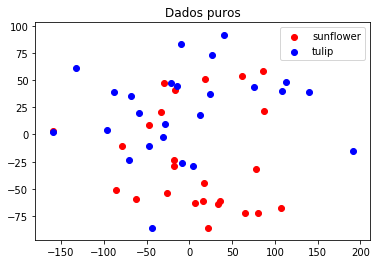

In [0]:
original_data = pca.fit_transform(X_train.reshape((50, 268203))).T
original_data_df = pd.DataFrame(data={"x":original_data[0], 
                                      "y":original_data[1], 
                                      "label":y_train})

plot_2d_representation(original_data_df, "Dados puros")

Cada ponto do grafico acima representa uma das imagens que sera utilizada na fase de treinamento, a partir dele é possivel ver que os dados sem nenhum tratamento estão muito misturados no espaço.

In [0]:
%%time
features = deep_featuring_model.predict(X_train)

Wall time: 26.9 s


Uma vez que os dados originais foram preprocessados é possivel aplicar PCA novamente para verificar se o preprocessamento organizou melhor os pontos no espaço

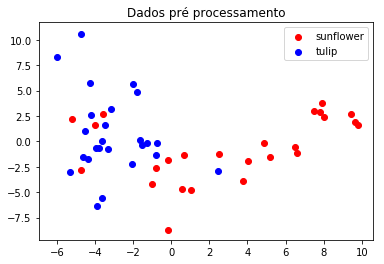

In [0]:
preprocessed_features = pca.fit_transform(features).T
preprocessed_features_df = pd.DataFrame(data={"x":preprocessed_features[0], 
                                              "y":preprocessed_features[1], 
                                              "label":y_train})

plot_2d_representation(preprocessed_features_df, "Dados pré processamento")

Neste novo gráfico é possivel ver que os dados estão visivelmente mais organizados no espaço, por isso é possivel classificar um novo ponto ate mesmo de forma puramente visual com certa precisão, desta forma não é difícil imaginar que um algoritimo baseado em espaço ira ter facilidade de performar uma classificação sobre esses dados.

### Preprocessamento dos dados de teste

In [0]:
%%time
features_test = deep_featuring_model.predict(X_test)

Wall time: 5min 48s


# Treinamento do Knn

Aqui iremos realizar o treino do KNN com as features que foram preprocessadas pelo modelo pretreinado.

In [0]:
%%time
clf = KNeighborsClassifier(5)
clf.fit(features, y_train)

Wall time: 0 ns


# Fase de teste do modelo proposto

In [0]:
pred_y = clf.predict(features_test)

## Acurácia

In [0]:
accuracy_score(y_test, pred_y)

0.8425

## Matriz de confusão

In [0]:
confusion_matrix(y_test, pred_y)

array([[324,  76],
       [ 50, 350]], dtype=int64)

## Desenpenho na predição

Uma vez que foi possível medir a qualidade da previsão é necessário medir a velocidade em que uma previsão é feita, para isso iremos tirar uma media do tempo que leva para classificar uma unica imagem.

In [0]:
single_image = X_test[7:8]

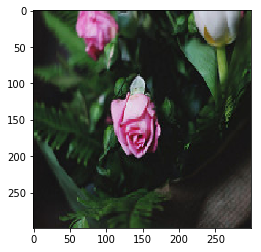

In [0]:
plt.imshow(single_image[0])

In [0]:
print("Classificação: " + clf.predict(deep_featuring_model.predict(single_image))[0])

Classificação: tulip


In [0]:
%%timeit
clf.predict(deep_featuring_model.predict(single_image))

473 ms ± 4.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Modelo de comparação

Apesar de os resultados acima serem bem animadores é necessário compara-los com outras abordagens, por isso iremos criar um outro modelo que ira desempenhar a mesma tarefa porem com uma abordagem mais comum, utilizaremos o mesmo modelo pretreinado sem algumas camadas porem desta vez adicionaremos mais camadas no fianl da rede neural e treinaremos apenas esssas novas camadas.

## Monstagem do modelo

In [0]:
comp_base_model = iv3.InceptionV3(weights='imagenet', include_top=False)

Agora que ja possuimos o modelo sem suas ultimas camadas é necessário adicionar as novas camadas e congelar as demais camadas para evitar que os seus pesos sejam atualizados, isso sera feitos nas proximas duas celulas

In [0]:
x = comp_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

comp_model = Model(inputs=comp_base_model.input, outputs=predictions)

In [0]:
for layer in comp_base_model.layers:
    layer.trainable = False

## Treninamento

In [0]:
comp_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
%%time
comp_model.fit(X_train, raw_y_train, epochs=30)

Epoch 1/30
50/50 [==============================] - 21s 413ms/step - loss: 0.8159 - acc: 0.5800
Epoch 2/30
50/50 [==============================] - 16s 326ms/step - loss: 2.3301 - acc: 0.5800
Epoch 3/30
50/50 [==============================] - 15s 301ms/step - loss: 0.3474 - acc: 0.8600
Epoch 4/30
50/50 [==============================] - 15s 301ms/step - loss: 0.6676 - acc: 0.6200
Epoch 5/30
50/50 [==============================] - 15s 300ms/step - loss: 0.6403 - acc: 0.5600
Epoch 6/30
50/50 [==============================] - 15s 302ms/step - loss: 0.2416 - acc: 0.9600
Epoch 7/30
50/50 [==============================] - 15s 304ms/step - loss: 0.3673 - acc: 0.8200
Epoch 8/30
50/50 [==============================] - 15s 309ms/step - loss: 0.2060 - acc: 0.9400
Epoch 9/30
50/50 [==============================] - 15s 305ms/step - loss: 0.1449 - acc: 0.9600
Epoch 10/30
50/50 [==============================] - 15s 305ms/step - loss: 0.3383 - acc: 0.8200
Epoch 11/30
50/50 [====================

In [0]:
%%time
comp_pred_y = comp_model.predict(X_test)

Wall time: 6min 9s


In [0]:
new_comp_pred_y = get_array_classes(comp_pred_y)

## Testes do modelo

In [0]:
accuracy_score(new_comp_pred_y, y_test)

0.71625

In [0]:
confusion_matrix(new_comp_pred_y, y_test)

array([[391, 218],
       [  9, 182]], dtype=int64)

## Desenpenho na previsão

In [0]:
%%timeit
comp_model.predict(single_image)

667 ms ± 93.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Considerações finais

Apesar de as diferenças de desempenho serem grintantes é importante ter em mente que esses resultados não são absolutos, algumas modificações simples no treinamento do segundo modelo, como usar imagens com dimensões menores por exemplo, gerariam resultados muito mais proximos do que foi visto no modelo proposto.

O tempo de previsão é outro fator que deve ser levado em consideração, o modelo proposto levou pouco mais de meio segundo para classificar uma imagem, apesar de ter mostrado uma acuracia satisfatória ele se mostrou mutio lento e portando seu uso em tarefaza como analese video em tempo real é desencorajado.

# Informações adicionais

Especificações do computador utilizado nos testes:

- Processador: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz 2.81GHz
- RAM: 8.00 GB
- SO: Windows 10 Home Single Language

Todos os testes foram realizados utilizando apenas a CPU